In [1]:
import os
import torch #Main PyTorch library
import torch.nn as nn #To define neural networks (Generator & Discriminator)
from torchvision import datasets, transforms, utils #For image transformations and dataset utilities
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt #To show generated images 
from tqdm import tqdm #Adds progress bars during training

In [2]:
data_dir = r"C:\Users\AA070812\Downloads\Data Science Projects\GAN_imagegeneration\face"

# Training params
image_size = 64        # Resize all images to 64x64
z_dim = 100            # Random noise vector size
batch_size = 128       # How many images per training step
num_epochs = 10        # Number of times to go over the dataset
lr = 0.0002            # Learning rate
beta1 = 0.5            # Adam optimizer parameter

device = torch.device("cpu")  # Forces use of CPU

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Resize & CenterCrop: All images become 64x64.
# ToTensor: Converts image to PyTorch tensor.
# Normalize: Maps pixel values from [0,1] to [-1,1] (used with Tanh()).

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

Epoch [1/10]: 100%|█████████████████████████████████████████████| 1583/1583 [3:13:19<00:00,  7.33s/it, D=0.388, G=5.87]


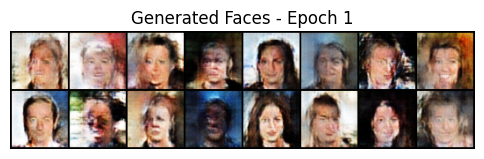

Epoch [2/10]: 100%|█████████████████████████████████████████████| 1583/1583 [3:38:41<00:00,  8.29s/it, D=0.319, G=5.47]


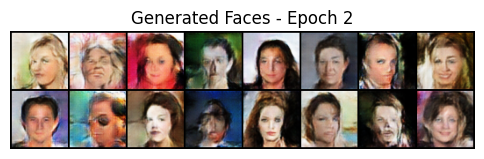

Epoch [3/10]: 100%|████████████████████████████████████████████| 1583/1583 [3:37:43<00:00,  8.25s/it, D=0.0909, G=3.18]


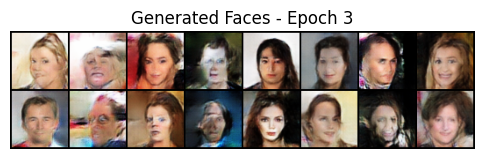

Epoch [4/10]: 100%|█████████████████████████████████████████████| 1583/1583 [4:19:10<00:00,  9.82s/it, D=0.111, G=4.05]


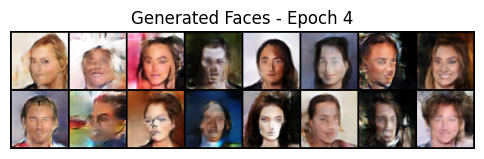

Epoch [5/10]: 100%|████████████████████████████████████████████| 1583/1583 [5:56:07<00:00, 13.50s/it, D=0.0762, G=4.09]


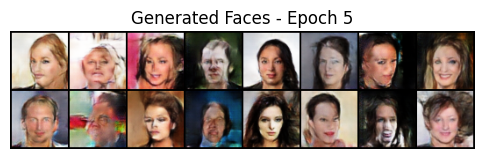

Epoch [6/10]: 100%|█████████████████████████████████████████████| 1583/1583 [3:01:59<00:00,  6.90s/it, D=0.132, G=2.82]


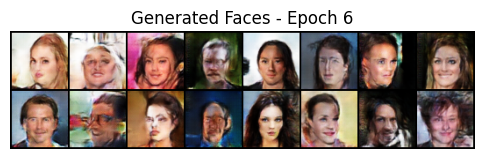

Epoch [7/10]: 100%|█████████████████████████████████████████████| 1583/1583 [1:50:38<00:00,  4.19s/it, D=0.694, G=13.8]


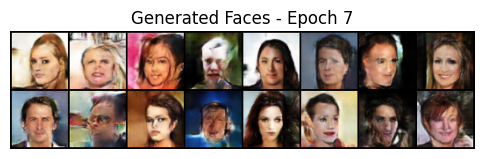

Epoch [8/10]: 100%|██████████████████████████████████████████████| 1583/1583 [10:30:01<00:00, 23.88s/it, D=0.0384, G=4]


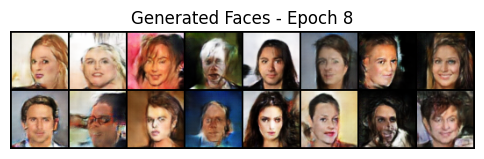

Epoch [9/10]: 100%|██████████████████████████████████████████████| 1583/1583 [2:09:23<00:00,  4.90s/it, D=0.171, G=3.1]


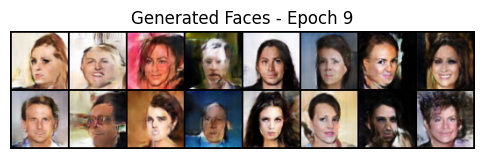

Epoch [10/10]: 100%|████████████████████████████████████████████| 1583/1583 [1:53:25<00:00,  4.30s/it, D=0.109, G=4.06]


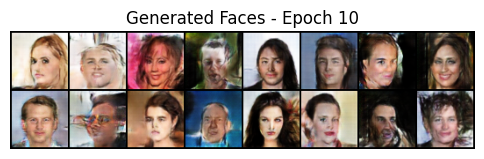

In [6]:
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

loss_fn = nn.BCELoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(16, z_dim, 1, 1).to(device)

for epoch in range(num_epochs):
    loop = tqdm(dataloader)
    for i, (real, _) in enumerate(loop):
        real = real.to(device)
        noise = torch.randn(real.size(0), z_dim, 1, 1).to(device)
        fake = gen(noise)

        # Train Discriminator
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)
        lossD = (loss_fn(disc_real, torch.ones_like(disc_real)) + loss_fn(disc_fake, torch.zeros_like(disc_fake))) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # Train Generator
        output = disc(fake).view(-1)
        lossG = loss_fn(output, torch.ones_like(output))
        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(D=lossD.item(), G=lossG.item())

    # Save Sample Output
    with torch.no_grad():
        sample = gen(fixed_noise).cpu()
        grid = utils.make_grid(sample, normalize=True)
        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Generated Faces - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()